# 09.1f: Cluster L1 Distances

**Compute pairwise L1 (taxicab) distances for dense cluster tokens**

## Why L1?

If tokens sit on a discrete lattice where each dimension is quantized to multiples of ε, then:

$$d_1(\mathbf{u}, \mathbf{v}) = \sum_{d=1}^{2560} |u_d - v_d| = \sum_{d=1}^{2560} n_d \cdot \varepsilon = \varepsilon \sum_{d=1}^{2560} n_d$$

This means **L1 distances should be integer multiples of ε** if there's lattice structure.

Looking for:
- Sharp peaks in histogram of d₁/ε at integer values
- Discrete spikes vs smooth distribution

## Strategy

1. Load dense cluster vectors from 09.1e
2. Compute all pairwise L1 distances
3. Save for analysis in 09.2e

Expected: ~124 vectors → ~15k pairwise distances

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
CLUSTER_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"
CLUSTER_TOKEN_IDS_KEY = "token_ids"

# Output file
OUTPUT_FILE = "cluster_l1_distances.safetensors"
DISTANCES_KEY = "distances_l1"
VECTORS_KEY = "vectors"
TOKEN_IDS_KEY = "token_ids"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Dense Cluster

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading dense cluster...")
cluster_data = load_file(data_dir / CLUSTER_FILE)
vectors = cluster_data[CLUSTER_VECTORS_KEY]
token_ids = cluster_data[CLUSTER_TOKEN_IDS_KEY]

n_vectors = len(vectors)
d = vectors.shape[1]

print(f"  Cluster size: {n_vectors:,} unique vectors")
print(f"  Dimensions:   {d:,}")
print(f"  Memory:       {vectors.numel() * 4 / 1e6:.2f} MB")
print()

print("✓ Data loaded")

Loading dense cluster...
  Cluster size: 124 unique vectors
  Dimensions:   2,560
  Memory:       1.27 MB

✓ Data loaded


## Compute Pairwise L1 Distances

L1 (taxicab) distance: $d_1(\mathbf{u}, \mathbf{v}) = \sum_i |u_i - v_i|$

In [4]:
print(f"Computing pairwise L1 distances for {n_vectors:,} vectors...")
print(f"  Expected: {n_vectors:,}² = {n_vectors**2:,} pairwise distances")
print()

# Expand for broadcasting
v1 = vectors.unsqueeze(1)  # [n, 1, d]
v2 = vectors.unsqueeze(0)  # [1, n, d]

# Compute L1 distances
print("Computing component-wise absolute differences...")
diffs = torch.abs(v1 - v2)  # [n, n, d]

print("Summing over dimensions (L1 norm)...")
distances_l1 = diffs.sum(dim=2)  # [n, n]

print(f"\nDistance matrix shape: {distances_l1.shape}")
print(f"Memory: {distances_l1.numel() * 4 / 1e6:.2f} MB")
print()

print("✓ Pairwise L1 distances computed")

Computing pairwise L1 distances for 124 vectors...
  Expected: 124² = 15,376 pairwise distances

Computing component-wise absolute differences...
Summing over dimensions (L1 norm)...

Distance matrix shape: torch.Size([124, 124])
Memory: 0.06 MB

✓ Pairwise L1 distances computed


## Distance Statistics

In [5]:
print("L1 distance statistics:\n")

# Mask diagonal (self-distances = 0)
mask = torch.eye(n_vectors, dtype=torch.bool)
distances_off_diag = distances_l1[~mask]

print(f"All pairwise L1 distances (off-diagonal):")
print(f"  Min:    {distances_off_diag.min().item():.6e}")
print(f"  Max:    {distances_off_diag.max().item():.6e}")
print(f"  Mean:   {distances_off_diag.mean().item():.6e}")
print(f"  Median: {distances_off_diag.median().item():.6e}")
print(f"  Std:    {distances_off_diag.std().item():.6e}")
print()

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("Percentiles:")
for p in percentiles:
    val = torch.quantile(distances_off_diag, p / 100.0).item()
    print(f"  {p:2d}%: {val:.6e}")
print()

print("✓ Statistics computed")

L1 distance statistics:

All pairwise L1 distances (off-diagonal):
  Min:    7.450581e-09
  Max:    6.000546e-02
  Mean:   5.338653e-03
  Median: 9.630694e-04
  Std:    1.054413e-02

Percentiles:
   1%: 3.725290e-08
   5%: 1.599640e-05
  10%: 3.891438e-05
  25%: 1.000538e-04
  50%: 9.631066e-04
  75%: 3.329009e-03
  90%: 1.603020e-02
  95%: 3.749146e-02
  99%: 4.364406e-02

✓ Statistics computed


## Quick Preview: Distribution Shape

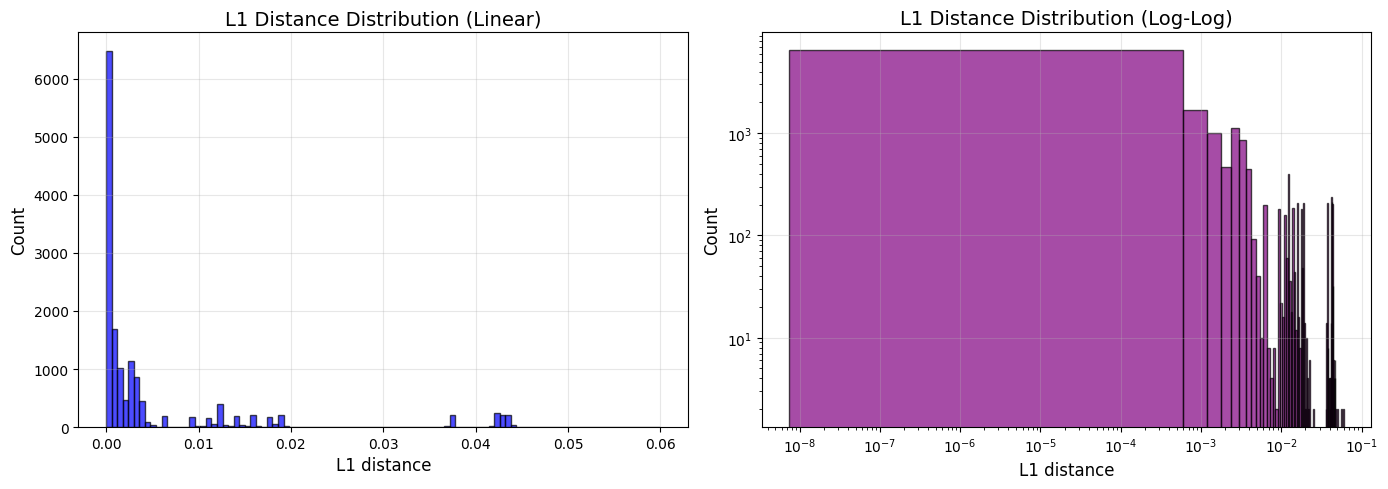

✓ Preview plotted

(Full analysis in 09.2e)


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

distances_np = distances_off_diag.cpu().numpy()

# Panel 1: Linear histogram
ax = axes[0]
ax.hist(distances_np, bins=100, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('L1 distance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('L1 Distance Distribution (Linear)', fontsize=14)
ax.grid(True, alpha=0.3)

# Panel 2: Log-log
ax = axes[1]
ax.hist(distances_np, bins=100, alpha=0.7, color='purple', edgecolor='black')
ax.set_xlabel('L1 distance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('L1 Distance Distribution (Log-Log)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Preview plotted")
print("\n(Full analysis in 09.2e)")

## Save Results

In [7]:
output_path = data_dir / OUTPUT_FILE

print(f"Saving L1 distances to {output_path}...\n")

save_file({
    DISTANCES_KEY: distances_l1,
    VECTORS_KEY: vectors,
    TOKEN_IDS_KEY: token_ids
}, output_path)

print(f"  Cluster size:      {n_vectors:,} vectors")
print(f"  Distance matrix:   {n_vectors:,} × {n_vectors:,}")
print(f"  File size:         {output_path.stat().st_size / 1e6:.2f} MB")
print()
print(f"✓ Results saved to {OUTPUT_FILE}")

Saving L1 distances to ../data/tensors/cluster_l1_distances.safetensors...

  Cluster size:      124 vectors
  Distance matrix:   124 × 124
  File size:         1.33 MB

✓ Results saved to cluster_l1_distances.safetensors


## Summary

In [8]:
print("="*80)
print("L1 DISTANCE COMPUTATION SUMMARY")
print("="*80)
print()
print(f"Cluster vectors:     {n_vectors:,}")
print(f"Pairwise distances:  {n_vectors**2:,}")
print()
print(f"L1 distance statistics:")
print(f"  Min:    {distances_off_diag.min().item():.6e}")
print(f"  Max:    {distances_off_diag.max().item():.6e}")
print(f"  Median: {distances_off_diag.median().item():.6e}")
print()
print("="*80)

L1 DISTANCE COMPUTATION SUMMARY

Cluster vectors:     124
Pairwise distances:  15,376

L1 distance statistics:
  Min:    7.450581e-09
  Max:    6.000546e-02
  Median: 9.630694e-04



## Conclusion

**What we computed:**
- Pairwise L1 (taxicab) distances for all vectors in dense cluster
- Distance matrix saved for lattice structure analysis

**Next step:**
- 09.2e: Analyze d₁/ε distribution to detect lattice quantization
  - Look for sharp peaks at integer multiples of ε
  - Compare to L∞ structure
  - Test lattice hypothesis